# **Week2 복습과제**

**1. [ANN]**

**2. [CNN]**

- 데이터는 Week 1 과 같이 MNIST (0-9 숫자 분류) 데이터셋입니다.
- 이때, 우리의 복습과제에서는 0-4 숫자 분류를 위한 데이터 샘플만 사용할 예정입니다
- 아래 코드를 실행시켜 주세요

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import random

# Tensor 변환을 위함
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST 데이터셋 불러오기
train_dataset = MNIST(root='C:\Euron\Week2', train=True, transform=transform, download=True)
test_dataset = MNIST(root='C:\Euron\Week2', train=False, transform=transform, download=True)

# 무작위로 샘플 인덱스 선택
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1, 2, 3, 4]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1, 2, 3, 4]]

# Subset을 사용하여 샘플링된 데이터셋 생성
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)


# DataLoader 생성
batch_size = 64  # 배치 크기는 64로 설정 (batch_size를 다르게 실행해보셔도 좋습니다)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:11<00:00, 896kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 127kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.83MB/s]


In [ ]:
# 데이터셋 크기 확인을 위해 해당 셀을 실행시켜 주세요
print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")

Train dataset size: 30596
Test dataset size: 5139


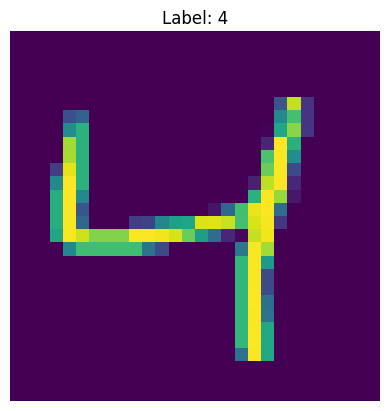

In [ ]:
# 데이터셋 중 하나의 이미지를 시각화해보기
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 하나의 샘플 가져오기
image, label = train_subset[1]

# 텐서를 NumPy 배열로 변환
image = image.numpy().squeeze()

# 이미지 출력
plt.imshow(image)  # 이미지 표시
plt.title(f"Label: {label}")  # 레이블 표시
plt.axis("off")  # 축 없애기
plt.show()

<a id="1"></a> <br>
## **1. ANN**

**인공 신경망 (ANN)**

>  로지스틱 회귀는 분류 문제에서 성능이 좋지만, 데이터의 비선형성이 증가하면 모델의 정확도가 감소합니다.

>  따라서, hidden lyaer 에 더 많은 비선형 함수를 추가시켜 모델의 복잡도를 증가시켜 봅시다. 😀

↪ **3개의 hidden layer를 쌓고 다양한 활성화 함수 ReLU, Tanh, ELU 사용해봅시다**


In [ ]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn

#### **ANN 모델 생성**

In [ ]:
# ANN Model
class ANNModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        # Linear function 1: ____ --> ____  (입력 차원에서 숨겨진 계층으로)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1 (ReLU 활성화 함수)
        self.relu1 = nn.ReLU()

        # Linear function 2: ____ --> ____  (숨겨진 계층을 한 번 더 통과)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2 (Tanh 활성화 함수 사용)
        self.tanh2 = nn.Tanh()

        # Linear function 3: ____ --> ____  (추가 숨겨진 계층)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3 (ELU 활성화 함수)
        self.elu3 = nn.ELU()

        # Linear function 4: ____ --> ____  (마지막 출력층)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.elu3(out)

        # Linear function 4
        out = self.fc4(out)  # 마지막 출력층
        return out

In [ ]:
# ANN 객체 생성
input_dim = 784  # 이미지 크기 (28x28)
hidden_dim = 150  # 하이퍼파라미터 (150으로 설정)
output_dim = 5  # 출력 클래스 개수 (0~4)


model = ANNModel(input_dim,hidden_dim,output_dim)
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss() # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
learning_rate = 0.02
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

#### **ANN 모델 학습**

In [ ]:
# ANN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트

# 전체 학습
for epoch in range(10):

    # 배치 단위 학습
    for i, (images, labels) in enumerate(train_loader):

        # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
        train = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
        labels = labels  # 텐서 형태 유지

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        # 모델을 이용해 예측값(outputs) 계산
        outputs = model(train)

        # 손실 계산
        # cross entropy loss를 사용해 예측값과 실제값 비교
        loss = loss_ftn(outputs, labels)

        # Backward propagation - 손실에 대한 기울기 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            # 정확도 계산을 위한 변수 초기화
            correct = 0
            total = 0


            # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
            for images, labels in test_loader:

                test = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs =model(test)

                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # 손실 및 정확도 출력
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.009098069742321968  Accuracy: 97.78166961669922 %
Iteration: 1000  Loss: 0.10737879574298859  Accuracy: 96.18602752685547 %
Iteration: 1500  Loss: 0.06891961395740509  Accuracy: 97.7232894897461 %
Iteration: 2000  Loss: 0.05316753312945366  Accuracy: 96.40007781982422 %
Iteration: 2500  Loss: 0.0421232134103775  Accuracy: 95.60225677490234 %
Iteration: 3000  Loss: 0.10177978873252869  Accuracy: 97.02276611328125 %
Iteration: 3500  Loss: 0.13364911079406738  Accuracy: 95.17415618896484 %
Iteration: 4000  Loss: 0.08489766716957092  Accuracy: 96.78926086425781 %
Iteration: 4500  Loss: 0.1362246423959732  Accuracy: 96.7503433227539 %


#### **ANN 학습 결과**

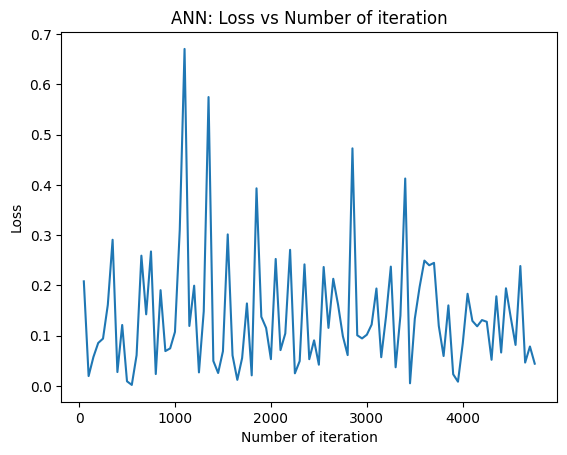

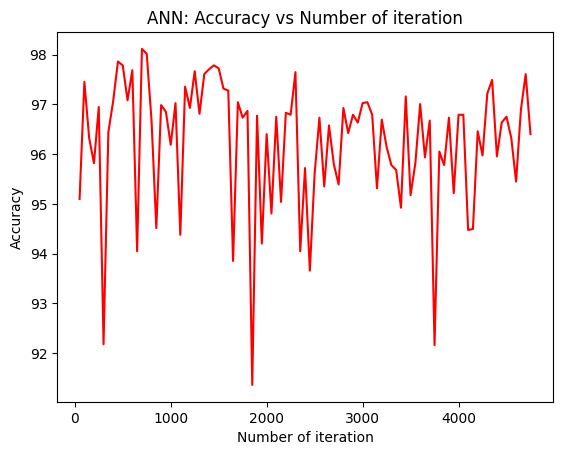

In [ ]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 시각화된 모델의 학습 결과를 해석해주세요.** 🤗



---
**[해석]**
- loss가 전체적으로 감소하는 추세지만 진동이 크고 불안정함 => learning rate을 더 작게하면 좀 더 안정적으로 변할 것 같음
- 94~98% 정도의 꽤 높은 정확도를 보임


#### **ANN 최적의 하이퍼파라미터 찾기**

1️⃣ **실험 1: Hidden Dimension 최적값 찾기**
- hidden_dim 값을 50-200 사이 값들로 설정하고 모델을 학습
- 각 hidden_dim 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교




2️⃣ **실험 2: Learning Rate 최적값 찾기**

- learning_rate 값을 0.1-0.005 사이 값들로 설정하고 모델을 학습
- 각 learning_rate 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교



**⚠ 이때 epoch 값은 자유롭게 해주셔도 됩니다! **

In [ ]:
# 실험 1 hidden_dims=[50-200 사이 값들] 로 학습

loss_results = {}
iteration_results = {}
accuracy_results = {}

for hidden_dim in range(50, 201, 50):
    model = ANNModel(input_dim,hidden_dim,output_dim)
    loss_ftn = nn.CrossEntropyLoss()
    learning_rate = 0.02
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    count = 0
    loss_list = []  # Loss 저장 리스트
    iteration_list = []  # Iteration 저장 리스트
    accuracy_list = []  # 정확도 저장 리스트

    # 전체 학습
    for epoch in range(5):

    # 배치 단위 학습
        for i, (images, labels) in enumerate(train_loader):

            # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
            train = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
            labels = labels  # 텐서 형태 유지

            # 옵티마이저의 기울기 초기화
            optimizer.zero_grad()

            # Forward
            # 모델을 이용해 예측값(outputs) 계산
            outputs = model(train)

            # 손실 계산
            # cross entropy loss를 사용해 예측값과 실제값 비교
            loss = loss_ftn(outputs, labels)

            # Backward propagation - 손실에 대한 기울기 계산
            loss.backward()

            # 가중치 업데이트
            optimizer.step()
            count += 1

            if count % 50 == 0:
              # 정확도 계산을 위한 변수 초기화
              correct = 0
              total = 0


              # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
              for images, labels in test_loader:

                test = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs =model(test)

                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
              accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
              loss_list.append(loss.item())
              iteration_list.append(count)
              accuracy_list.append(accuracy)

    loss_results[hidden_dim] = loss_list
    iteration_results[hidden_dim] = iteration_list
    accuracy_results[hidden_dim] = accuracy_list

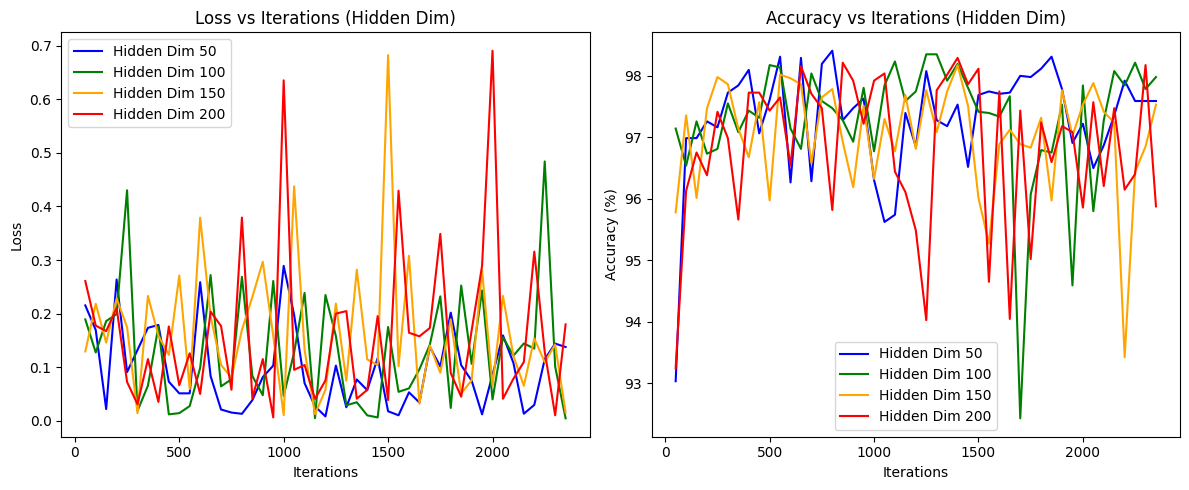

In [ ]:
# 실험 1 모델 학습 결과 시각화
colors = ['blue', 'green', 'orange', 'red']
hidden_dims = list(loss_results.keys())  # 저장된 hidden_dim 값 가져오기

plt.figure(figsize=(12, 5))

# 🔹 (왼쪽) Loss vs Iterations 그래프
plt.subplot(1, 2, 1)
for i, hidden_dim in enumerate(hidden_dims):
    plt.plot(iteration_results[hidden_dim], loss_results[hidden_dim], label=f'Hidden Dim {hidden_dim}', color=colors[i])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations (Hidden Dim)')
plt.legend()

# 🔹 (오른쪽) Accuracy vs Iterations 그래프
plt.subplot(1, 2, 2)
for i, hidden_dim in enumerate(hidden_dims):
    plt.plot(iteration_results[hidden_dim], accuracy_results[hidden_dim], label=f'Hidden Dim {hidden_dim}', color=colors[i])
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Iterations (Hidden Dim)')
plt.legend()

# 전체 그래프 출력
plt.tight_layout()
plt.show()

**해당 셀의 마크 다운을 풀고 hidden dimension 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- hidden dimension이 커질수록 loss 변화가 커지고 불안정해짐 이는 뉴런 수가 많을수록 모델이 더 복잡해지고, 학습 중 불안정성이 증가하기 때문이다.
- Accuracy도 loss와 마찬가지로 hidden dimension이 커질수록 변동 폭이 커진다.


In [ ]:
# 실험 2 learning_rates=[0.1-0.005 사이 값들] 로 학습
learning_rates = [0.1, 0.05, 0.02, 0.005]

loss_results = {}
iteration_results = {}
accuracy_results = {}

for lr in learning_rates:
    model = ANNModel(input_dim,hidden_dim,output_dim)
    loss_ftn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    count = 0
    loss_list = []  # Loss 저장 리스트
    iteration_list = []  # Iteration 저장 리스트
    accuracy_list = []  # 정확도 저장 리스트

    # 전체 학습
    for epoch in range(5):

    # 배치 단위 학습
        for i, (images, labels) in enumerate(train_loader):

            # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
            train = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
            labels = labels  # 텐서 형태 유지

            # 옵티마이저의 기울기 초기화
            optimizer.zero_grad()

            # Forward
            # 모델을 이용해 예측값(outputs) 계산
            outputs = model(train)

            # 손실 계산
            # cross entropy loss를 사용해 예측값과 실제값 비교
            loss = loss_ftn(outputs, labels)

            # Backward propagation - 손실에 대한 기울기 계산
            loss.backward()

            # 가중치 업데이트
            optimizer.step()
            count += 1

            if count % 50 == 0:
              # 정확도 계산을 위한 변수 초기화
              correct = 0
              total = 0


              # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
              for images, labels in test_loader:

                test = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs =model(test)

                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
              accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
              loss_list.append(loss.item())
              iteration_list.append(count)
              accuracy_list.append(accuracy)

    loss_results[lr] = loss_list
    iteration_results[lr] = iteration_list
    accuracy_results[lr] = accuracy_list

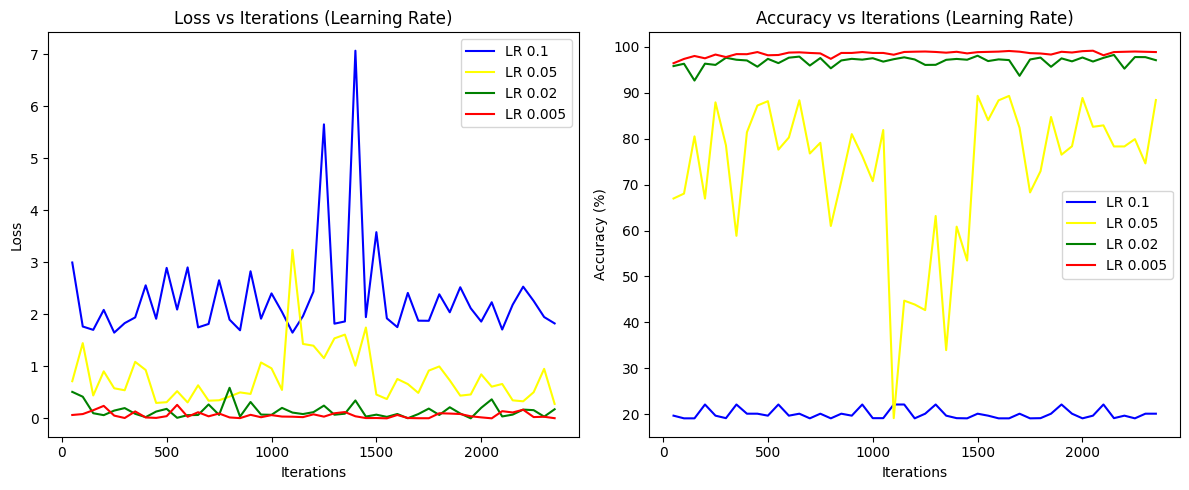

In [ ]:
# 실험 2 모델 학습 결과 시각화
colors = ['blue', 'yellow', 'green', 'red']
plt.figure(figsize=(12, 5))

# 🔹 (왼쪽) Loss vs Iterations 그래프
plt.subplot(1, 2, 1)
for i, lr in enumerate(learning_rates):
    plt.plot(iteration_results[lr], loss_results[lr], label=f'LR {lr}', color=colors[i])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations (Learning Rate)')
plt.legend()

# 🔹 (오른쪽) Accuracy vs Iterations 그래프
plt.subplot(1, 2, 2)
for i, lr in enumerate(learning_rates):
    plt.plot(iteration_results[lr], accuracy_results[lr], label=f'LR {lr}', color=colors[i])
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Iterations (Learning Rate)')
plt.legend()

# 전체 그래프 출력
plt.tight_layout()
plt.show()

**해당 셀의 마크 다운을 풀고 learning rate 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- learning rate가 작아질수록 loss와 accuracy 그래프가 안정적이고, 각각 감소하는 지수함수와 증가하는 로그함수의 형태를 띌 것이라고 예상하였으나, 생각과는 많이 다른 이상한 그래프가 출력되어 앞선 코드의 문제가 있는것으로 보인다
- 문제가 있어보이지만 그래프를 해석해보면 그래도 learning rate가 낮을 때(0.02, 0.005) loss와 accuracy 변동이 크지 않고 낮은 loss 값과 높은 정확도를 보임 반면에, learning rate가 높을 때(0.1, 0.05)는 너무 많이 이동하여서 global minimum을 찾지 못한 것으로 해석됨

<a id="1"></a> <br>
## **2. CNN**
> CNN은 이미지 분류에 적합한 모델로, kernel을 이용해 feature map을 생성합니다

**↪ 2개의 합성곱 계층을 쌓고, 활성화 함수로 ReLU를 사용하며,Max Pooling layer를 적용해봅시다.**

#### **CNN 모델 생성**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Model 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # 합성곱 계층 1 (Conv Layer 1)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # kernel size를 2로 설정

        # 합성곱 계층 2 (Conv Layer 2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # kernel size를 2로 설정

        # Fully Connected Layer
        self.fc1 = nn.Linear(32*4*4, 5)  # 입력 차원 및 출력 차원 지정

    def forward(self, x):
        # 합성곱 계층 1 + 활성화 함수
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max Pooling 1
        out = self.maxpool1(out)

        # 합성곱 계층 2 + 활성화 함수
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max Pooling 2
        out = self.maxpool2(out)

        # feature map을 flatten하게
        out = out.view(out.size(0), -1)

        # 완전 연결 계층
        out = self.fc1(out)

        return out


In [ ]:
# CNN 객체 생성
model = CNNModel()
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss()  # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # 학습률을 자유롭게 설정해주세요

#### **CNN 모델 학습**

In [ ]:
# CNN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트
num_epochs = 20  # 학습할 에포크 수 설정 -> 자유롭게 설정해주셔도 됩니다

for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크별 손실 초기화

    for images, labels in train_loader:

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # 손실 계산
        loss = loss_ftn(outputs, labels)

        # Backward
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()
        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            correct = 0
            total = 0

            with torch.no_grad():  # 평가
                for images, labels in test_loader:
                    # 모델 예측 수행
                    outputs = model(images)

                    # 가장 확률이 높은 클래스 선택
                    predicted = torch.max(outputs, 1)[1]

                    # 총 샘플 수 및 올바른 예측 개수 누적
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

    # 매 에포크마다 평균 손실 출력
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.1705074971444547
Epoch 2, Loss: 0.1072391204337642
Epoch 3, Loss: 0.08480978740227559
Epoch 4, Loss: 0.07009549904225826
Epoch 5, Loss: 0.05957783689909072
Epoch 6, Loss: 0.051394981483536106
Epoch 7, Loss: 0.045474865839822465
Epoch 8, Loss: 0.040841054479982354
Epoch 9, Loss: 0.036627099925597706
Epoch 10, Loss: 0.033699309161722285
Epoch 11, Loss: 0.031171824003177032
Epoch 12, Loss: 0.028711848145536494
Epoch 13, Loss: 0.02712066963753451
Epoch 14, Loss: 0.025724383813516424
Epoch 15, Loss: 0.0242546156101271
Epoch 16, Loss: 0.022395044982254444
Epoch 17, Loss: 0.021318732364117052
Epoch 18, Loss: 0.020045683103844927
Epoch 19, Loss: 0.018903858532170553
Epoch 20, Loss: 0.01886196074254387


#### **CNN 학습 결과**

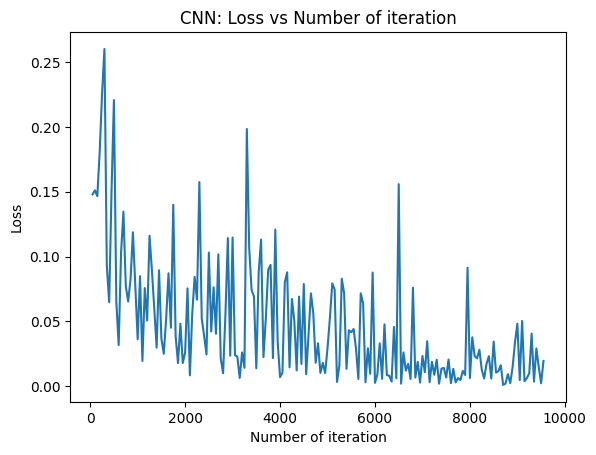

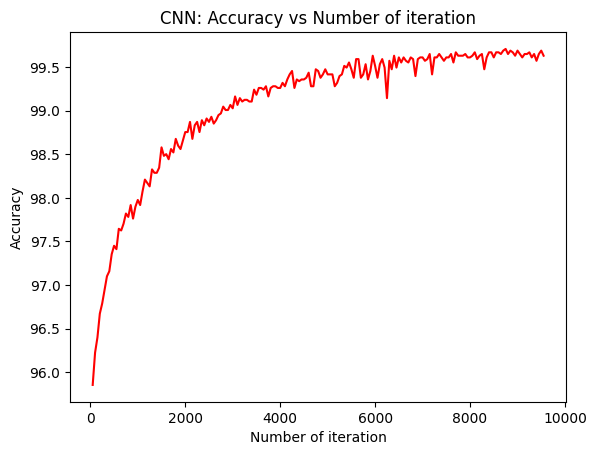

In [ ]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 MNIST 데이터셋에서 ANN, CNN의 학습 결과 비교와 함께 두 모델에 대해 각각 짧게 소개해주세요.** 🤗



---
**[답변]**
- 이미지 데이터인 MNIST 데이터셋에서 ANN 보다 CNN에서 더 높은 정확도를 보이고, loss와 accuracy가 더 안정적으로 수렴하는 모습을 보임.
- 이미지 데이터 분석에 최적화된 신경망인 CNN은 ANN과 달리 데이터의 공간적 구조를 무시하지 않기 때문에 이미지 데이터인 MNIST에서 더 강점을 보임.
